# Modelling

Finding the ideal model for recommending restuarants to users

In [337]:
import os
import time
import json
import pickle
from collections import Counter

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# import databricks.koalas as ks

import pyspark
from pyspark.sql import SparkSession
import pandas as pd

# Setup a SparkSession
spark = SparkSession.builder.getOrCreate()

import pandas_profiling
# df.profile_report(style={'full_width':True})
# df.profile_report(title='Pandas Profiling Report')

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
plt.style.use('seaborn')
font = {'size':16}
import seaborn as sns

from sklearn.metrics import mean_absolute_error

import surprise
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline
from surprise import SVD, SVDpp, NMF
from surprise import accuracy
from surprise import SlopeOne, CoClustering
from surprise.model_selection import train_test_split

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter('ignore')

In [21]:
def notify(title, text):
    os.system("""
              osascript -e 'display notification "{}" with title "{}"'
              """.format(text, title))

notify("Test Title", "Heres an alert")

## Reading in AZNV dataframe

In [87]:
AZNV_df = pd.read_pickle('../data/AZNV_df.p')
print(AZNV_df.shape)
AZNV_df.head(2)

(1818490, 32)


,business_id,name_x,address,city,state,postal_code,latitude,longitude,stars_x,review_count_x,is_open,attributes,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date,name_y,review_count_y,yelping_since,friends,fans,average_stars,likes,compliments,elite_years,hotel?
0,vx4YAA02Qz6khRD1fZ1MFA,Ping Pang Pong,4000 W Flamingo Rd,Las Vegas,NV,89103,36.116901,-115.193512,3.5,1005,1,"{'RestaurantsPriceRange2': '2', 'BusinessAccep...","[Cantonese, Seafood, Dim Sum, Restaurants, Chi...","{'Monday': '10:0-3:0', 'Tuesday': '10:0-3:0', ...",FwiJ7DQ3a9cBwp1OYlP5VA,A0kENtCCoVT3m7T35zb2Vg,2.0,0,0,0,There are so many good reviews of this place o...,2010-04-02 20:37:54,Anastasia,348,2009-02-15 16:45:34,"BBY1Alonk5V0OLgk_G0rNQ, TY7QgNKJEhvo1zCULlT9Rg...",9,3.66,619,38,3,0
1,glTBzDHv9wNhEsZa4bQrOA,CatHouse Boutique Nightclub,3900 Las Vegas Blvd S,Las Vegas,NV,89119,36.094822,-115.173216,3.0,178,0,"{'OutdoorSeating': 'False', 'BusinessAcceptsCr...","[Restaurants, Nightlife, Lounges, American (Ne...","{'Monday': '17:0-4:0', 'Tuesday': '17:0-4:0', ...",7ynnTyXiuIWHDkktHsdm4Q,A0kENtCCoVT3m7T35zb2Vg,2.0,1,1,0,"Restaurant-only review; based on that, they wo...",2009-02-16 14:53:11,Anastasia,348,2009-02-15 16:45:34,"BBY1Alonk5V0OLgk_G0rNQ, TY7QgNKJEhvo1zCULlT9Rg...",9,3.66,619,38,3,0


In [88]:
np.mean(AZNV_df['stars_x'])

3.7818712228277307

### Create numerical features for IDs

In [89]:
user_labels, user_uniques = pd.factorize(AZNV_df['user_id'])
business_labels, business_uniques = pd.factorize(AZNV_df['business_id'])

AZNV_df['userid'] = user_labels
AZNV_df['businessid'] = business_labels

### Create pandas and spark DF for recommender models

In [90]:
pandas_df = AZNV_df[['userid', 'businessid', 'stars_y']]
pandas_df = pandas_df.rename(columns={"businessid": "restaurantid", "stars_y":"rating"})

pandas_df.head()

,userid,restaurantid,rating
0,0,0,2.0
1,0,1,2.0
2,0,2,1.0
3,0,3,4.0
4,0,4,5.0


In [91]:
pandas_df.to_pickle('../data/model_pandas_df.p')

In [92]:
pandas_df = pd.read_pickle('../data/model_pandas_df.p')
pandas_df.head(2)

,userid,restaurantid,rating
0,0,0,2.0
1,0,1,2.0


In [93]:
spark_df = spark.createDataFrame(pandas_df)

## ALS Model - Base Model

Train ALS model using np.mean of ratings

In [94]:
train, test = spark_df.randomSplit([0.8, 0.2], seed=0)

train.show(5)

train.count()

+------+------------+------+
|userid|restaurantid|rating|
+------+------------+------+
|     0|           1|   2.0|
|     0|           2|   1.0|
|     0|           4|   5.0|
|     0|           6|   5.0|
|     0|           7|   3.0|
+------+------------+------+
only showing top 5 rows



1455147

In [95]:
train_with_mean = train.toPandas()
train_with_mean['rating'] = np.mean(train_with_mean['rating'])
train_with_mean = spark.createDataFrame(train_with_mean)
train_with_mean.show(2)

+------+------------+------------------+
|userid|restaurantid|            rating|
+------+------------+------------------+
|     0|           1|3.7893498045214677|
|     0|           2|3.7893498045214677|
+------+------------+------------------+
only showing top 2 rows



In [96]:
from pyspark.ml.recommendation import ALS
als_model = ALS(
    itemCol='restaurantid',
    userCol='userid',
    ratingCol='rating',
    nonnegative=True,    
    regParam=0.1,
    rank=10) 

recommender = als_model.fit(train_with_mean)

print('ALS model has been fitted on train_with_mean data.')

ALS model has been fitted on train_with_mean data.


In [97]:
# look at a random prediction

data = [(0, 3)]
columns = ('userid', 'restaurantid')
one_row_spark_df = spark.createDataFrame(data, columns)
user_factor_df = recommender.userFactors.filter('id = 1')
item_factor_df = recommender.itemFactors.filter('id = 100')
user_factors = user_factor_df.collect()[0]['features']
item_factors = item_factor_df.collect()[0]['features']
recommender.transform(one_row_spark_df).show()

+------+------------+----------+
|userid|restaurantid|prediction|
+------+------------+----------+
|     0|           3| 3.6294148|
+------+------------+----------+



In [98]:
predictions = recommender.transform(test)
predictions.describe().show()

+-------+-----------------+------------------+------------------+----------+
|summary|           userid|      restaurantid|            rating|prediction|
+-------+-----------------+------------------+------------------+----------+
|  count|           363343|            363343|            363343|    363343|
|   mean|67019.54313692571| 4357.848828792628|3.7901789768896057|       NaN|
| stddev|56886.59800722874|3628.5879309853876|1.3181072931108382|       NaN|
|    min|                0|                 0|               1.0| 2.9763389|
|    max|           203358|             14796|               5.0|       NaN|
+-------+-----------------+------------------+------------------+----------+



In [99]:
# Dump the predictions to Pandas DataFrames to make our final calculations easier
predictions_df = predictions.toPandas()
train_df = train.toPandas()

In [100]:
# Fill any missing values with the mean rating
predictions_df = predictions.toPandas().fillna(train_df['rating'].mean())

In [101]:
# Calculate Root Mean Squared Error (RMSE)

predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['prediction'])**2

rmse = np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))

print('RMSE of base (train data with mean): {}'.format(rmse))

RMSE of base (train data with mean): 1.3274137815483629


In [104]:
# Calculate Mean Absolute Error (MAE)

y_true = predictions_df['rating']
y_pred = predictions_df['prediction']
mae = mean_absolute_error(y_true, y_pred)

print('MAE of base (train data with mean): {}'.format(mae))

MAE of base (train data with mean): 1.141648958873738


### RMSE 1.3274 is the score to beat!

Using RMSE because it punishes error more highly than MAE

## ALS on train dataset

In [13]:
from pyspark.ml.recommendation import ALS
als_model = ALS(
    itemCol='restaurantid',
    userCol='userid',
    ratingCol='rating',
    nonnegative=True,    
    regParam=0.1,
    rank=10) 

recommender = als_model.fit(train)

print('ALS model has been fitted on train data.')

ALS model has been fitted on train data.


In [14]:
predictions = recommender.transform(test)
predictions_df = predictions.toPandas()
train_df = train.toPandas()
predictions_df = predictions.toPandas().fillna(train_df['rating'].mean())

predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['prediction'])**2

rmse = np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))

print('RMSE of train: {}'.format(rmse))

RMSE of train: 1.4427868868935185


In [15]:
predictions_df.head()

,userid,restaurantid,rating,prediction,squared_error
0,29054,148,5.0,4.522486,0.228020
1,14514,148,3.0,2.615818,0.147596
2,122710,148,4.0,3.924699,0.005670
3,14958,148,3.0,3.699966,0.489952
4,106608,148,3.0,2.643519,0.127078


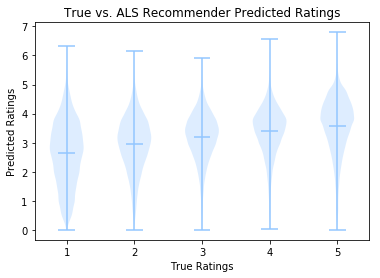

In [16]:
# Create array of predictions for violinplot
data = [predictions_df['prediction'][predictions_df['rating'] == rating].values for rating in range(1, 6)]
plt.violinplot(data, range(1,6), showmeans=True, )
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title('True vs. ALS Recommender Predicted Ratings')
plt.show();

### Model turned out to be worse than the base...

## Collaborative Filtering

Item-Item Collaborative Filtering (IBCF) measures the similarity between the items that target users rates/ interacts with and other items

#### Advantages of item-based filtering over user-based filtering :

* Computationally less expensive : When users >> items, It makes sense to use item-based filtering in this case. 
* Item-item is less sparse than user-user matrix
* A famous example of item-based filtering is <a href = 'https://www.cs.umd.edu/~samir/498/Amazon-Recommendations.pdf'>Amazon’s recommendation engine</a>.

## Surprise library

<a href='http://surpriselib.com/'>Surprise library</a> is a great tool for building and analyzing recommender models.
<br><br>
Thank you to bmanohar16's work used as reference

### Split data into train/test

In [17]:
pandas_df.shape

(1818490, 3)

In [18]:
print('Unique Users    :', pandas_df.userid.nunique())
print('Unique Restaurant :', pandas_df.restaurantid.nunique())
print('Unique Ratings  :', pandas_df.rating.nunique())

Unique Users    : 203359
Unique Restaurant : 14797
Unique Ratings  : 5


In [208]:
# Set Rating Scale
reader = Reader(rating_scale=(1, 5))

# Load data with rating scale
data = Dataset.load_from_df(pandas_df, reader)

In [210]:
trainset, testset = train_test_split(data, test_size=.25, random_state=0)

### KNN Basic

computes similiarities between item-item where k=40 (down to 1 if less than 40)

In [7]:
start = time.time()

sim_options = {'name': 'cosine',
               'user_based': False  # compute  similarities between items
               }
algo = KNNBasic(sim_options=sim_options)

knnbasic_cv = cross_validate(algo, data, cv=5, n_jobs=-1, verbose=True)

end = time.time()
print('\nthis took {:.2f} seconds to run'.format(end-start))
notify("Notification", "Model is complete")

Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3620  1.3590  1.3630  1.3586  1.3600  1.3605  0.0017  
MAE (testset)     1.0236  1.0218  1.0249  1.0202  1.0224  1.0226  0.0016  
Fit time          30.83   31.05   30.42   31.61   28.49   30.48   1.07    
Test time         21.81   20.72   22.87   19.97   18.51   20.78   1.50    
this took 235.93 seconds to run


### KNNWithMeans

A basic collaborative filtering algorithm, taking into account the mean ratings of each user.
<br>
* Using an item-item similiarity measure with k between 1 and 40

In [8]:
start = time.time()

sim_options = {'name': 'cosine',
               'user_based': False  # compute  similarities between items
               }
algo = KNNWithMeans(sim_options=sim_options)

knnmeans_cv = cross_validate(algo, data, cv=5, n_jobs=-1, verbose=True)

end = time.time()
print('\nthis took {:.2f} seconds to run'.format(end-start))
notify("Notification", "Model is complete")

Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2530  1.2540  1.2519  1.2546  1.2522  1.2531  0.0010  
MAE (testset)     0.9448  0.9454  0.9445  0.9462  0.9435  0.9449  0.0009  
Fit time          28.53   31.86   29.81   29.90   29.04   29.83   1.13    
Test time         24.83   21.97   21.61   20.79   20.49   21.94   1.54    

this took 230.03 seconds to run


NameError: name 'notify' is not defined

### KNNWithZScore

A basic collaborative filtering algorithm, taking into account
the z-score normalization of each user.

In [11]:
start = time.time()

sim_options = {'name': 'cosine',
               'user_based': False  # compute  similarities between items
               }
algo = KNNWithZScore(sim_options=sim_options)

knnz_cv = cross_validate(algo, data, cv=5, n_jobs=-1, verbose=True)

end = time.time()
print('\nthis took {:.2f} seconds to run'.format(end-start))
notify("Notification", "Model is complete")

Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2524  1.2543  1.2562  1.2551  1.2549  1.2546  0.0012  
MAE (testset)     0.9397  0.9414  0.9441  0.9418  0.9417  0.9417  0.0014  
Fit time          32.71   37.81   36.07   34.22   31.72   34.50   2.21    
Test time         30.26   27.80   26.57   24.80   23.21   26.53   2.43    

this took 255.27 seconds to run


TypeError: notify() missing 2 required positional arguments: 'subtitle' and 'message'

### KNNBaseline

A basic collaborative filtering algorithm taking into account a baseline rating.



In [347]:
start = time.time()

sim_options = {'name': 'cosine',
               'shrinkage': 0  # no shrinkage
#                'user_based': False  # compute  similarities between items
               }
algo = KNNBaseline(sim_options=sim_options)

knn_baseline = cross_validate(algo, data, cv=5, n_jobs=-1, verbose=True)

end = time.time()
print('\nthis took {:.2f} seconds to run'.format(end-start))
notify("Notification", "Model is complete")

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGKILL(-9)}

### Matrix Factorization Based Algorithms

In [13]:
start = time.time()

svd_cv = cross_validate(SVD(), data, cv=5, n_jobs=-1, verbose=True)

end = time.time()
print('\nthis took {:.2f} seconds to run'.format(end-start))
notify("Notification", "Model is complete")

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1934  1.1932  1.1936  1.1928  1.1940  1.1934  0.0004  
MAE (testset)     0.9465  0.9464  0.9477  0.9469  0.9473  0.9470  0.0005  
Fit time          110.08  114.72  112.34  105.94  101.61  108.94  4.67    
Test time         5.15    4.39    3.91    3.82    3.75    4.21    0.52    

this took 309.10 seconds to run


TypeError: notify() missing 2 required positional arguments: 'subtitle' and 'message'

In [22]:
start = time.time()

svdpp_cv = cross_validate(SVDpp(), data, cv=5, n_jobs=-1, verbose=True)

end = time.time()
print('\nthis took {:.2f} seconds to run'.format(end-start))
notify("Notification", "Model is complete")

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1993  1.1993  1.1989  1.2015  1.1970  1.1992  0.0014  
MAE (testset)     0.9461  0.9471  0.9464  0.9475  0.9454  0.9465  0.0007  
Fit time          1414.89 1418.26 1417.86 1434.24 1408.60 1418.77 8.47    
Test time         31.60   31.58   21.10   19.11   19.95   24.67   5.69    

this took 1637.75 seconds to run


In [23]:
start = time.time()

nmf_cv = cross_validate(NMF(), data, cv=5, n_jobs=-1, verbose=True)

end = time.time()
print('\nthis took {:.2f} seconds to run'.format(end-start))
notify("Notification", "Model is complete")

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3246  1.3255  1.3246  1.3258  1.3243  1.3250  0.0006  
MAE (testset)     1.0165  1.0177  1.0169  1.0184  1.0172  1.0173  0.0007  
Fit time          119.38  124.66  126.34  121.72  108.79  120.18  6.18    
Test time         4.10    3.58    3.24    3.13    3.11    3.43    0.38    

this took 297.22 seconds to run


### Other Collaborative Filtering Algorithms

In [25]:
start = time.time()

slope_cv = cross_validate(SlopeOne(), data, cv=5, n_jobs=-1, verbose=True)

end = time.time()
print('\nthis took {:.2f} seconds to run'.format(end-start))
notify("Notification", "Model is complete")

Evaluating RMSE, MAE of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3077  1.3083  1.3050  1.3073  1.3042  1.3065  0.0016  
MAE (testset)     0.9811  0.9808  0.9797  0.9803  0.9792  0.9802  0.0007  
Fit time          14.29   14.33   14.50   19.49   15.18   15.56   1.99    
Test time         14.42   14.24   15.73   16.36   16.99   15.55   1.07    

this took 223.36 seconds to run


In [26]:
start = time.time()

coclus_cv = cross_validate(CoClustering(), data, cv=5, n_jobs=-1, verbose=True)

end = time.time()
print('\nthis took {:.2f} seconds to run'.format(end-start))
notify("Notification", "Model is complete")

Evaluating RMSE, MAE of algorithm CoClustering on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2726  1.2766  1.2751  1.2793  1.2711  1.2749  0.0029  
MAE (testset)     0.9500  0.9534  0.9528  0.9556  0.9505  0.9525  0.0020  
Fit time          36.92   35.66   38.36   35.02   32.95   35.78   1.82    
Test time         3.52    3.17    3.42    3.09    3.17    3.27    0.17    

this took 231.57 seconds to run


## Comparison of all algorithms on RMSE and MAE

#### Saving RMSE and MAE scores

In [61]:
save_scores = [knnbasic_cv, knnmeans_cv, knnz_cv, svd_cv, svdpp_cv, nmf_cv, slope_cv, coclus_cv]
outfile = '../data/RMSE_MAE_scores.png'

with open('outfile', 'wb') as fp:
    pickle.dump(save_scores, fp)

#### Reading back RMSE and MAE scores

In [ ]:
outfile = '../data/RMSE_MAE_scores.png'

with open ('outfile', 'rb') as fp:
    save_scores = pickle.load(fp)

#### Show results

In [182]:
print('Algorithm\t RMSE\t\t MAE')
print('--------------', '\t', '------', '\t', '------')
print('ALS with Means', '\t', round(rmse, 4), '\t', round(mae, 4))
print()
print('KNN Basic', '\t', round(knnbasic_cv['test_rmse'].mean(), 4), '\t', round(knnbasic_cv['test_mae'].mean(), 4))
print('KNN Means', '\t', round(knnmeans_cv['test_rmse'].mean(), 4), '\t', round(knnmeans_cv['test_mae'].mean(), 4))
print('KNN ZScore', '\t', round(knnz_cv['test_rmse'].mean(), 4), '\t', round(knnz_cv['test_mae'].mean(), 4))
print()
print('SVD', '\t\t', round(svd_cv['test_rmse'].mean(), 4), '\t', round(svd_cv['test_mae'].mean(), 4))
print('SVDpp', '\t\t', round(svdpp_cv['test_rmse'].mean(), 4), '\t', round(svdpp_cv['test_mae'].mean(), 4))
print('NMF', '\t\t', round(nmf_cv['test_rmse'].mean(), 4), '\t\t', round(nmf_cv['test_mae'].mean(), 4))
print()
print('SlopeOne', '\t', round(slope_cv['test_rmse'].mean(), 4), '\t', round(slope_cv['test_mae'].mean(), 4))
print('CoClustering', '\t', round(coclus_cv['test_rmse'].mean(), 4), '\t', round(coclus_cv['test_mae'].mean(), 4))

Algorithm	 RMSE		 MAE
-------------- 	 ------ 	 ------
ALS with Means 	 1.3274 	 1.1416

KNN Basic 	 1.3605 	 1.0226
KNN Means 	 1.2531 	 0.9449
KNN ZScore 	 1.2546 	 0.9417

SVD 		 1.1934 	 0.947
SVDpp 		 1.1992 	 0.9465
NMF 		 1.325 		 1.0173

SlopeOne 	 1.3065 	 0.9802
CoClustering 	 1.2749 	 0.9525


### Plotting RMSE / MAE via bar graph

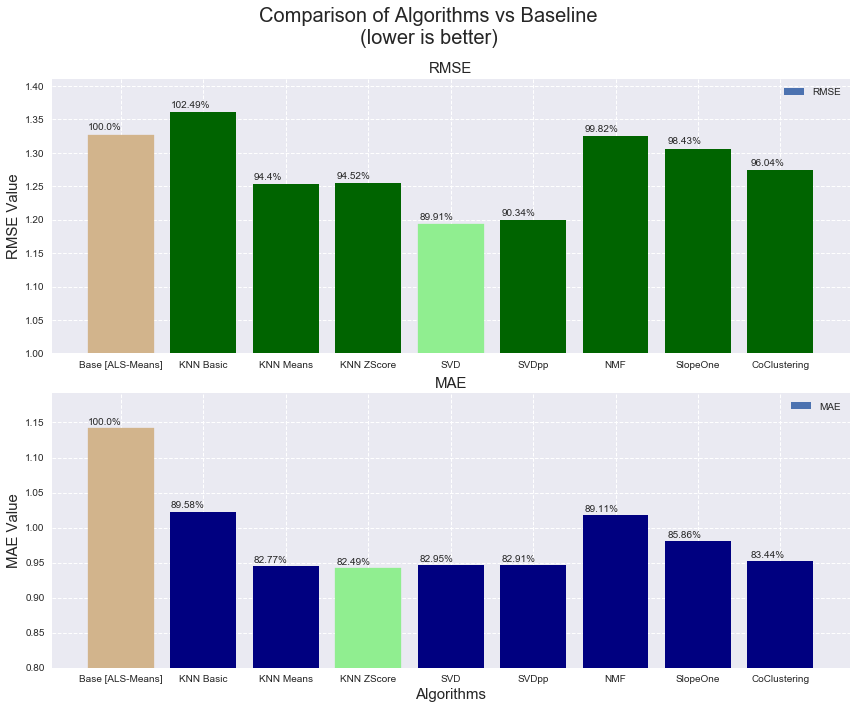

In [366]:
x_algo = ['KNN Basic', 'KNN Means', 'KNN ZScore', 'SVD', 'SVDpp', 'NMF', 'SlopeOne', 'CoClustering']
all_algos_cv = [knnbasic_cv, knnmeans_cv, knnz_cv, svd_cv, svdpp_cv, nmf_cv, slope_cv, coclus_cv]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_algos_cv]
mae_cv = [round(res['test_mae'].mean(), 4) for res in all_algos_cv]

# manually adding base score data
x_algo = ['Base [ALS-Means]']+x_algo
rmse_cv = [1.3274]+rmse_cv
mae_cv = [1.1416]+mae_cv

# fig, axarr = plt.subplots(2, 2)
# fig.suptitle("This Main Title is Nicely Formatted", fontsize=16)

# axarr[0, 0].plot(x, y)
# axarr[0, 0].set_title('Axis [0,0] Subtitle')
# axarr[0, 1].scatter(x, y)
# axarr[0, 1].set_title('Axis [0,1] Subtitle')
# axarr[1, 0].plot(x, y ** 2)
# axarr[1, 0].set_title('Axis [1,0] Subtitle')
# axarr[1, 1].scatter(x, y ** 2)
# axarr[1, 1].set_title('Axis [1,1] Subtitle')

# # # Fine-tune figure; hide x ticks for top plots and y ticks for right plots
# plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
# plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)

# # Tight layout often produces nice results
# # but requires the title to be spaced accordingly
# fig.tight_layout()
# fig.subplots_adjust(top=0.88)


fig, ax = plt.subplots(2,1, figsize=(12,10))
fig.suptitle('Comparison of Algorithms vs Baseline\n(lower is better)', fontsize=20, verticalalignment='top')
ax[0].set_title('RMSE', loc='center', fontsize=15)
c = ax[0].bar(x_algo, rmse_cv, label='RMSE', color='darkgreen')
c[0].set_color('tan')
c[4].set_color('lightgreen')
ax[0].set_ylim(bottom=1.0, top=max(rmse_cv)+.05)  
# ax[0].plot(x_algo, rmse_cv, label='RMSE', color='darkred', marker='o')
# ax[0].set_xlabel('Algorithms', fontsize=15)
ax[0].set_ylabel('RMSE Value', fontsize=15)
patch = mpatches.Patch(label='RMSE')
ax[0].legend(handles=[patch])
ax[0].grid(ls='dashed')

# ax[1].set_title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
ax[1].set_title('MAE', loc='center', fontsize=15)
c = ax[1].bar(x_algo, mae_cv, label='MAE', color='navy')
c[0].set_color('tan')
c[3].set_color('lightgreen')
ax[1].set_ylim(bottom=0.8, top=max(mae_cv)+.05)  
ax[1].set_xlabel('Algorithms', fontsize=15)
ax[1].set_ylabel('MAE Value', fontsize=15)
patch = mpatches.Patch(label='MAE')
ax[1].legend(handles=[patch])
ax[1].grid(ls='dashed')

# annotate bar graph 1
base0=1.3274
percent0 = [round(n/base0*100,2) for n in rmse_cv]
for i,p in enumerate(ax[0].patches):
#     ax[0].annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    ax[0].annotate(str(percent0[i])+'%', (p.get_x() * 1.005, p.get_height() * 1.005))
    
# annotate bar graph 2
base1=1.1416
percent1 = [round(n/base1*100,2) for n in mae_cv]
for i,p in enumerate(ax[1].patches):
    ax[1].annotate(str(percent1[i])+'%', (p.get_x() * 1.005, p.get_height() * 1.005))

plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.savefig('../img/rmse_mae_barchart.png', dpi=350, alpha=0)
plt.show();

### Plotting RMSE/MAE via plt.plot

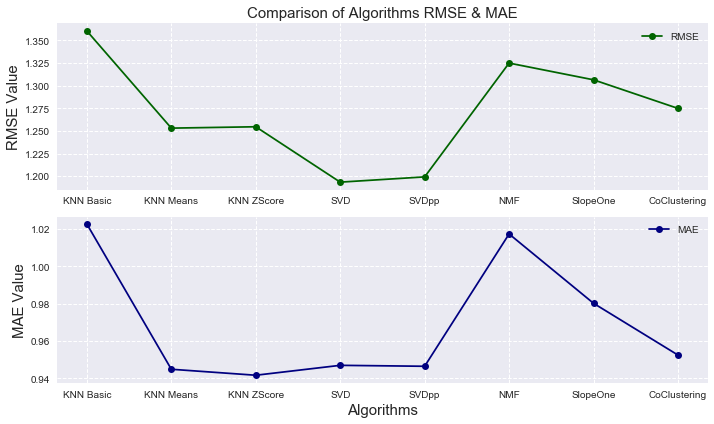

In [251]:
x_algo = ['KNN Basic', 'KNN Means', 'KNN ZScore', 'SVD', 'SVDpp', 'NMF', 'SlopeOne', 'CoClustering']
all_algos_cv = [knnbasic_cv, knnmeans_cv, knnz_cv, svd_cv, svdpp_cv, nmf_cv, slope_cv, coclus_cv]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_algos_cv]
mae_cv = [round(res['test_mae'].mean(), 4) for res in all_algos_cv]

fig, ax = plt.subplots(2,1, figsize=(10,6))
ax[0].set_title('Comparison of Algorithms RMSE & MAE', loc='center', fontsize=15)
ax[0].plot(x_algo, rmse_cv, label='RMSE', color='darkgreen', marker='o')
# ax[0].set_xlabel('Algorithms', fontsize=15)
ax[0].set_ylabel('RMSE Value', fontsize=15)
ax[0].legend()
ax[0].grid(ls='dashed')

# ax[1].set_title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
ax[1].plot(x_algo, mae_cv, label='MAE', color='navy', marker='o')
ax[1].set_xlabel('Algorithms', fontsize=15)
ax[1].set_ylabel('MAE Value', fontsize=15)
ax[1].legend()
ax[1].grid(ls='dashed')

plt.tight_layout()
plt.savefig('../img/rmse_mae_plotchart.png', dpi=300, transparency=True)
plt.show();

## Evaluation Results

<b>Best RMSE</b>: SVD
<br>
<b>Best MAE</b>: KNN ZScore

<font color='green'><h2>Winner SVD!! </h2></font>

However SVD and SVDpp both give good results, let's tune the hyperparameters to find the best RMSE score

## Tune hyperparameters using GridSearchCV

In [78]:
svd_param_grid = {'n_epochs': [5, 10], 
                  'lr_all': [0.007, 0.009, 0.01],
                  'reg_all': [0.2, 0.5]}

start = time.time()

svdpp_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1, joblib_verbose=2)
svdpp_gs.fit(data)

end = time.time()
print('svdpp_gs took {:.2f} seconds'.format(end-start))
notify("Notification", "Model is complete")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 12.5min


svdpp_gs took 2920.02 seconds


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 48.3min finished


In [79]:
print('SVDpp - RMSE:', round(svdpp_gs.best_score['rmse'], 4), '- MAE:', round(svdpp_gs.best_score['mae'], 4))

SVDpp - RMSE: 1.1775 - MAE: 0.9439


In [80]:
svd_param_grid = {'n_epochs': [5, 10], 
                  'lr_all': [0.007, 0.009, 0.01],
                  'reg_all': [0.2, 0.5]}

start = time.time()

svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1, joblib_verbose=2)
svd_gs.fit(data)

end = time.time()
print('svd_gs took {:.2f} seconds'.format(end-start))
notify("Notification", "Model is complete")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 12.5min


svd_gs took 1830.10 seconds


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 30.1min finished


In [81]:
print('SVD   - RMSE:', round(svd_gs.best_score['rmse'], 4), '- MAE:', round(svd_gs.best_score['mae'], 4))

SVD   - RMSE: 1.1776 - MAE: 0.944


In [295]:
x = svdpp_gs.cv_results['params']
y1 = svdpp_gs.cv_results['mean_test_rmse']
y2 = svdpp_gs.cv_results['mean_test_mae']

y3 = svd_gs.cv_results['mean_test_rmse']
y4 = svd_gs.cv_results['mean_test_mae']

In [305]:
x = [str(x1) for x1 in x]
x

["{'n_epochs': 5, 'lr_all': 0.007, 'reg_all': 0.2}",
 "{'n_epochs': 5, 'lr_all': 0.007, 'reg_all': 0.5}",
 "{'n_epochs': 5, 'lr_all': 0.009, 'reg_all': 0.2}",
 "{'n_epochs': 5, 'lr_all': 0.009, 'reg_all': 0.5}",
 "{'n_epochs': 5, 'lr_all': 0.01, 'reg_all': 0.2}",
 "{'n_epochs': 5, 'lr_all': 0.01, 'reg_all': 0.5}",
 "{'n_epochs': 10, 'lr_all': 0.007, 'reg_all': 0.2}",
 "{'n_epochs': 10, 'lr_all': 0.007, 'reg_all': 0.5}",
 "{'n_epochs': 10, 'lr_all': 0.009, 'reg_all': 0.2}",
 "{'n_epochs': 10, 'lr_all': 0.009, 'reg_all': 0.5}",
 "{'n_epochs': 10, 'lr_all': 0.01, 'reg_all': 0.2}",
 "{'n_epochs': 10, 'lr_all': 0.01, 'reg_all': 0.5}"]

### Graphing the GridSearchCV results

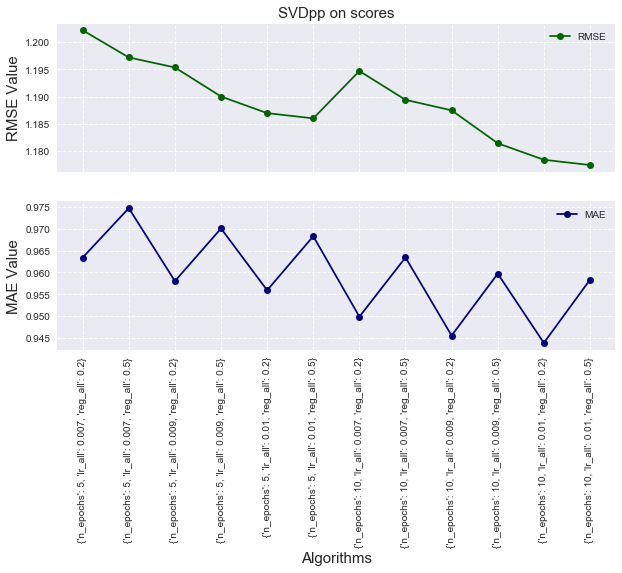

In [317]:
index = [1, 3, 5, 7, 9, 11, 0, 2, 4, 6, 8, 10]

xx = []
yy = []
for i, j in enumerate(x):
    xx = xx+[x[index[i]]]
    yy = yy+[y1[index[i]]]

fig, ax = plt.subplots(2,1, figsize=(10,6))
ax[0].set_title('SVDpp on scores', loc='center', fontsize=15)
ax[0].plot([str(x1) for x1 in xx], yy, label='RMSE', color='darkgreen', marker='o')
ax[0].set_xticklabels(['','','','','',''])
# ax[0].barh([str(x1) for x1 in x], y1)
# ax[0].set_xlabel('Algorithms', fontsize=15)
ax[0].set_ylabel('RMSE Value', fontsize=15)
ax[0].legend()
ax[0].grid(ls='dashed')

# ax[1].set_title('SVDpp on MAE', loc='center', fontsize=15)
ax[1].plot([str(x1) for x1 in xx], y2, label='MAE', color='navy', marker='o')
ax[1].set_xticklabels([str(x1) for x1 in x], rotation=90)
ax[1].set_xlabel('Algorithms', fontsize=15)
ax[1].set_ylabel('MAE Value', fontsize=15)
ax[1].legend()
ax[1].grid(ls='dashed')

plt.savefig('../img/SVDpp_scores.png', dpi=300, transparency=True)
plt.show();


In [303]:
y1

array([1.19469029, 1.20215595, 1.18941691, 1.19717721, 1.18749122,
       1.19534671, 1.18146586, 1.19002352, 1.178444  , 1.18698353,
       1.17747944, 1.18602452])

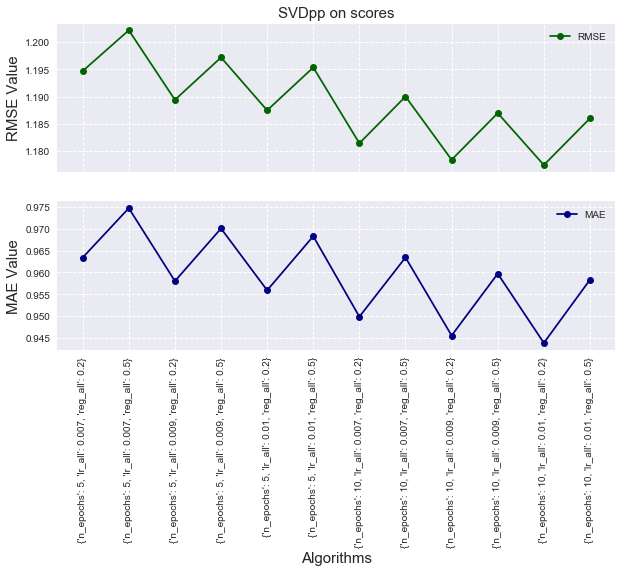

In [186]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
ax[0].set_title('SVDpp on scores', loc='center', fontsize=15)
ax[0].plot([str(x1) for x1 in x], y1, label='RMSE', color='darkgreen', marker='o')
ax[0].set_xticklabels(['','','','','',''])
# ax[0].barh([str(x1) for x1 in x], y1)
# ax[0].set_xlabel('Algorithms', fontsize=15)
ax[0].set_ylabel('RMSE Value', fontsize=15)
ax[0].legend()
ax[0].grid(ls='dashed')

# ax[1].set_title('SVDpp on MAE', loc='center', fontsize=15)
ax[1].plot([str(x1) for x1 in x], y2, label='MAE', color='navy', marker='o')
ax[1].set_xticklabels([str(x1) for x1 in x], rotation=90)
ax[1].set_xlabel('Algorithms', fontsize=15)
ax[1].set_ylabel('MAE Value', fontsize=15)
ax[1].legend()
ax[1].grid(ls='dashed')

plt.savefig('../img/SVDpp_scores.png', dpi=300, transparency=True)
plt.show();


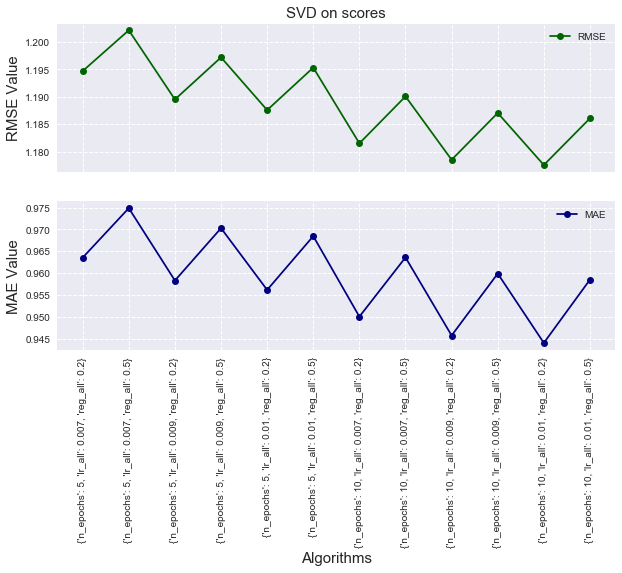

In [187]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
ax[0].set_title('SVD on scores', loc='center', fontsize=15)
ax[0].plot([str(x1) for x1 in x], y3, label='RMSE', color='darkgreen', marker='o')
ax[0].set_xticklabels(['','','','','',''])
# ax[0].barh([str(x1) for x1 in x], y1)
# ax[0].set_xlabel('Algorithms', fontsize=15)
ax[0].set_ylabel('RMSE Value', fontsize=15)
ax[0].legend()
ax[0].grid(ls='dashed')

# ax[1].set_title('SVDpp on MAE', loc='center', fontsize=15)
ax[1].plot([str(x1) for x1 in x], y4, label='MAE', color='navy', marker='o')
ax[1].set_xticklabels([str(x1) for x1 in x], rotation=90)
ax[1].set_xlabel('Algorithms', fontsize=15)
ax[1].set_ylabel('MAE Value', fontsize=15)
ax[1].legend()
ax[1].grid(ls='dashed')

plt.savefig('../img/SVD_scores.png', dpi=300, transparency=True)
plt.show();

## Best model = SVD++
* SVD++ (SVDpp) was marginally better than SVD in terms of RSME score (1.1775 vs 1.1776)
* SVD++ also took 50% longer to compute over SVD (45min vs 30min)
* SVD++ was also the best model from the <a href='http://buzzard.ups.edu/courses/2014spring/420projects/math420-UPS-spring-2014-gower-netflix-SVD.pdf'>$1M netflix competition</a> so it makes sense that it would work well in general

#### Final Hyperparameters
* epoch 10
* learning rate 0.01
* reg_all: 0.2

## Make Predictions using SVD++

on trainset/testset

In [213]:
start = time.time()

algo=SVDpp(n_epochs=10, lr_all=0.01, reg_all=0.2, random_state=0, verbose=True)
algo.fit(trainset)

end = time.time()
print('this process took {:.2f} seconds'.format(end-start))

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9


this process took 416.59 seconds


In [214]:
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 1.1798


1.1798422331791565

In [219]:
uid = 0
iid = 4
algo.predict(uid, iid)

Prediction(uid=0, iid=4, r_ui=None, est=3.6549299517898515, details={'was_impossible': False})

### First ten predictions

In [329]:
predictions[:10]

[Prediction(uid=20662, iid=3130, r_ui=4.0, est=4.055087464396904, details={'was_impossible': False}),
 Prediction(uid=43414, iid=7985, r_ui=4.0, est=2.9781895575634163, details={'was_impossible': False}),
 Prediction(uid=174275, iid=4419, r_ui=5.0, est=3.9836664388041534, details={'was_impossible': False}),
 Prediction(uid=187680, iid=9265, r_ui=5.0, est=3.9158135809179297, details={'was_impossible': False}),
 Prediction(uid=1062, iid=9380, r_ui=4.0, est=4.294048462289611, details={'was_impossible': False}),
 Prediction(uid=9807, iid=5042, r_ui=2.0, est=3.4248082127449866, details={'was_impossible': False}),
 Prediction(uid=52831, iid=559, r_ui=1.0, est=3.778683791648992, details={'was_impossible': False}),
 Prediction(uid=1809, iid=23, r_ui=5.0, est=4.36463509056888, details={'was_impossible': False}),
 Prediction(uid=3768, iid=3371, r_ui=2.0, est=3.9126327911530803, details={'was_impossible': False}),
 Prediction(uid=2656, iid=1935, r_ui=3.0, est=2.7564351959437463, details={'was_imp

In [333]:
AZNV_df.head()

,business_id,name_x,address,city,state,postal_code,latitude,longitude,stars_x,review_count_x,is_open,attributes,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date,name_y,review_count_y,yelping_since,friends,fans,average_stars,likes,compliments,elite_years,hotel?,userid,businessid
0,vx4YAA02Qz6khRD1fZ1MFA,Ping Pang Pong,4000 W Flamingo Rd,Las Vegas,NV,89103,36.116901,-115.193512,3.5,1005,1,"{'RestaurantsPriceRange2': '2', 'BusinessAccep...","[Cantonese, Seafood, Dim Sum, Restaurants, Chi...","{'Monday': '10:0-3:0', 'Tuesday': '10:0-3:0', ...",FwiJ7DQ3a9cBwp1OYlP5VA,A0kENtCCoVT3m7T35zb2Vg,2.0,0,0,0,There are so many good reviews of this place o...,2010-04-02 20:37:54,Anastasia,348,2009-02-15 16:45:34,"BBY1Alonk5V0OLgk_G0rNQ, TY7QgNKJEhvo1zCULlT9Rg...",9,3.66,619,38,3,0,0,0
1,glTBzDHv9wNhEsZa4bQrOA,CatHouse Boutique Nightclub,3900 Las Vegas Blvd S,Las Vegas,NV,89119,36.094822,-115.173216,3.0,178,0,"{'OutdoorSeating': 'False', 'BusinessAcceptsCr...","[Restaurants, Nightlife, Lounges, American (Ne...","{'Monday': '17:0-4:0', 'Tuesday': '17:0-4:0', ...",7ynnTyXiuIWHDkktHsdm4Q,A0kENtCCoVT3m7T35zb2Vg,2.0,1,1,0,"Restaurant-only review; based on that, they wo...",2009-02-16 14:53:11,Anastasia,348,2009-02-15 16:45:34,"BBY1Alonk5V0OLgk_G0rNQ, TY7QgNKJEhvo1zCULlT9Rg...",9,3.66,619,38,3,0,0,1
2,8Q6jl7OW8DZzwANggDspcw,Sugar Factory American Brasserie,"Paris Las Vegas Hotel, 3655 Las Vegas Blvd S",Las Vegas,NV,89109,36.112015,-115.172532,3.0,745,0,"{'RestaurantsDelivery': 'False', 'RestaurantsA...","[Brasseries, Bars, Breakfast & Brunch, Food, C...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",lO_55KRKtw2Rv1ZIHflX2w,A0kENtCCoVT3m7T35zb2Vg,1.0,0,0,0,"Are you allowed to post the phrase ""sh*t show""...",2012-04-26 01:23:24,Anastasia,348,2009-02-15 16:45:34,"BBY1Alonk5V0OLgk_G0rNQ, TY7QgNKJEhvo1zCULlT9Rg...",9,3.66,619,38,3,0,0,2
3,41b2SLmjLcxTGLVRxASiDA,Country Club,3131 Las Vegas Blvd S,Las Vegas,NV,89109,36.126720,-115.163553,4.0,269,0,"{'RestaurantsAttire': 'u'dressy'', 'Restaurant...","[Restaurants, Breakfast & Brunch, Seafood, Ame...","{'Monday': '0:0-0:0', 'Tuesday': '11:30-14:30'...",0WHDB3dNcUsybN4zRJbFzw,A0kENtCCoVT3m7T35zb2Vg,4.0,0,0,0,Our party of six enjoyed the Sunday jazz brunc...,2011-04-27 00:35:55,Anastasia,348,2009-02-15 16:45:34,"BBY1Alonk5V0OLgk_G0rNQ, TY7QgNKJEhvo1zCULlT9Rg...",9,3.66,619,38,3,0,0,3
4,Ehy00JWQixgoXzisVKhvag,Cucina by Wolfgang Puck,3720 S Las Vegas Blvd,Las Vegas,NV,89158,36.107677,-115.175062,4.0,921,1,"{'RestaurantsDelivery': 'False', 'RestaurantsP...","[Restaurants, Italian, Pizza]","{'Monday': '11:30-22:0', 'Tuesday': '11:30-22:...",tL3FZuCRK4q4d_bAF-VDOQ,A0kENtCCoVT3m7T35zb2Vg,5.0,0,0,0,This was the best surprise of our recent trip ...,2012-04-26 01:11:46,Anastasia,348,2009-02-15 16:45:34,"BBY1Alonk5V0OLgk_G0rNQ, TY7QgNKJEhvo1zCULlT9Rg...",9,3.66,619,38,3,0,0,4


In [343]:
summary_df = AZNV_df.groupby(['state', 'city', 'name_x', 'business_id', 'stars_x'])['review_id'].count().sort_values(axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last').to_frame()
summary_df = summary_df.reset_index()
summary_df.head(10)

,state,city,name_x,business_id,stars_x,review_id
0,NV,Las Vegas,Mon Ami Gabi,4JNXUYY8wbaaDmk3BPzlWw,4.0,5362
1,NV,Las Vegas,Bacchanal Buffet,RESDUcs7fIiihp38-d6_6g,4.0,5162
2,NV,Las Vegas,Wicked Spoon,K7lWdNUhCbcnEvI0NhGewg,3.5,4371
3,NV,Las Vegas,Earl of Sandwich,DkYS3arLOhA8si5uUEmHOw,4.5,3735
4,NV,Las Vegas,Hash House A Go Go,f4x1YBxkLrZg652xt2KR5g,4.0,3330
5,NV,Las Vegas,Gordon Ramsay BurGR,cYwJA2A6I12KNkm2rtXd5g,4.0,3159
6,NV,Las Vegas,Secret Pizza,iCQpiavjjPzJ5_3gPD5Ebg,4.0,3076
7,NV,Las Vegas,Lotus of Siam,KskYqH1Bi7Z_61pH6Om8pg,4.0,2771
8,NV,Las Vegas,The Buffet at Bellagio,ujHiaprwCQ5ewziu0Vi9rw,3.5,2762
9,NV,Las Vegas,Serendipity 3,eoHdUeQDNgQ6WYEnP2aiRw,3.0,2696


In [345]:
city_df = summary_df.groupby(['state', 'city'])['review_id'].sum().sort_values(axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last').to_frame()
city_df = city_df.reset_index()
city_df.head(10)

,state,city,review_id
0,NV,Las Vegas,807921
1,AZ,Phoenix,324853
2,AZ,Scottsdale,172281
3,AZ,Tempe,89927
4,NV,Henderson,85176
5,AZ,Chandler,68830
6,AZ,Mesa,66943
7,AZ,Gilbert,53971
8,AZ,Glendale,42317
9,AZ,Peoria,22914


## Get User Preferences

In [ ]:
Bacchanal Buffet
Wicked Spoon
Earl of Sandwich
Hash House A Go Go
Gordon Ramsay BurGR

In [ ]:
def recommend_restaurants(predictions, userID, df, original_ratings, num_recommendations):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = preds.iloc[user_row_number].sort_values(ascending=False) # User ID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings[original_ratings.user_id == (userID)]
    user_full = (user_data.merge(df, how = 'left', left_on = 'business_id', right_on = 'business_id').
                     sort_values(['rating'], ascending=False)
                 )
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (df[~df['business_id'].isin(user_full['business_id'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'business_id',
               right_on = 'business_id').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

In [ ]:
#https://medium.com/@james_aka_yale/the-4-recommendation-engines-that-can-predict-your-movie-tastes-bbec857b8223

In [ ]:
# get % recommendation and provide them back similiar cateogires
# look at submit.py from case study
# also let user choose top 5, different types of filters